In [1]:
library(RPostgreSQL)
library(tidyverse)

Loading required package: DBI
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
data_dir <- file.path("..", "data")
sql_dir <- file.path("..", "sql")

In [3]:
drv <- dbDriver("PostgreSQL")
con <- dbConnect(drv, dbname = "mimic")
dbSendQuery(con, "set search_path=echo,public,mimiciii;")

<PostgreSQLResult>

In [4]:
full_data <- dbGetQuery(con, "select * from merged_data")
head(full_data)

icustay_id,hadm_id,subject_id,first_careunit,intime,outtime,angus,age,icu_order,echo_time,⋯,lab_sodium_flag,lab_bun_flag,lab_bicarbonate_flag,lab_bnp_flag,lab_pco2_flag,lab_creatinine_flag,lab_potassium_flag,lab_troponin_flag,lab_po2_flag,lab_lactate_flag
228416,159895,5491,MICU,2151-06-29 01:18:27,2151-07-27 16:00:56,1,76.58225,1,2151-06-30,⋯,1,1,1,0,1,1,1,0,1,1
278148,169700,49395,MICU,2197-01-09 00:45:42,2197-01-10 06:46:29,1,82.72606,1,NA,⋯,1,1,1,0,0,1,1,0,0,0
274174,103722,14855,MICU,2181-09-08 23:43:13,2181-09-26 16:52:02,1,61.84390,1,2181-09-11,⋯,1,1,1,0,1,1,1,0,1,1
214954,170515,54642,MICU,2176-03-11 04:58:23,2176-03-15 18:00:48,1,63.86507,1,2176-03-11,⋯,1,1,1,0,1,1,1,1,1,1
222457,183493,96815,MICU,2105-06-04 20:57:55,2105-06-06 20:01:51,1,62.84018,1,NA,⋯,1,1,1,0,0,1,1,0,0,0
264413,134244,81436,MICU,2133-03-27 16:31:37,2133-04-04 16:15:28,1,62.60148,1,2133-03-31,⋯,1,1,1,0,0,1,1,0,0,1


In [5]:
dbDisconnect(con)
dbUnloadDriver(drv)

[1] TRUE

[1] TRUE

In [6]:
features <- c("age", "gender", "first_careunit", "weight",
              "saps", "sofa", "elix_score", "vent", "vaso", "sedative",
              "icd_chf", "icd_afib", "icd_renal", "icd_liver",
              "icd_copd", "icd_cad", "icd_stroke", "icd_malignancy", "icu_adm_weekday",
              "vs_map_first", "vs_heart_rate_first", "vs_temp_first", "vs_cvp_first",
              "lab_wbc_first", "lab_hemoglobin_first", "lab_platelet_first",
              "lab_sodium_first", "lab_potassium_first", "lab_bicarbonate_first",
              "lab_chloride_first", "lab_bun_first", "lab_lactate_first",
              "lab_creatinine_first", "lab_ph_first", "lab_po2_first", "lab_pco2_first",
              "lab_bnp_first", "lab_troponin_first", "lab_creatinine_kinase_first")

In [7]:
# missing <- full_data %>%
# select(grep("flag", names(.), value = TRUE)) %>%
# summarise_all(funs((1 - sum(.) / n()) * 100)) %>%
# gather("cov", "na") %>%
# mutate(cov = str_replace_all(cov, "_", " ")) %>%
# mutate(cov = str_replace_all(cov, "lab|vs|flag|icd|first", "")) %>%
# mutate(cov = str_replace_all(cov, "\\s+$|^\\s+", "")) %>%
# mutate(cov = tools::toTitleCase(cov))

# missing

In [8]:
missing <- full_data %>%
select(features) %>%
summarise_all(funs(sum(is.na(.)) / length(.) * 100)) %>%
gather("cov", "na") %>%
mutate(cov = str_replace_all(cov, "_", " ")) %>%
mutate(cov_ = cov) %>%
mutate(cov = str_replace_all(cov, "lab|vs|flag|icd|first", "")) %>%
mutate(cov = str_replace_all(cov, "\\s+$|^\\s+", "")) %>%
mutate(cov = case_when(
    grepl("icd|lab", cov_) ~ toupper(cov),
    TRUE ~ tools::toTitleCase(cov)
)) %>%
mutate(cov = case_when(
    cov == "Careunit" ~ "Service Unit",
    cov == "Weight" ~ "Weight",
    cov == "Elix Score" ~ "Elixhauser Score",
    cov == "Saps" ~ "SAPS Score",
    cov == "Sofa" ~ "SOFA Score",
    cov == "Vent" ~ "Ventilation Use (1st 24 Hrs)",
    cov == "Vaso" ~ "Vasopressor Use (1st 24 Hrs)",
    cov == "Sedative" ~ "Sedative Use (1st 24 Hrs)",
    cov == "Icu Adm Weekday" ~ "Day of ICU Admission",
    cov == "Icu Adm Hour" ~ "Hour of ICU Admission",
    cov == "Temp" ~ "Temperature",
    cov == "Map" ~ "MAP",
    cov == "Cvp" ~ "CVP",
    TRUE ~ cov
)) %>%
select(-cov_) %>%
mutate(flag = na > 50)

missing

cov,na,flag
Age,0.000000,FALSE
Gender,0.000000,FALSE
Service Unit,0.000000,FALSE
Weight,9.369596,FALSE
SAPS Score,0.000000,FALSE
SOFA Score,0.000000,FALSE
Elixhauser Score,0.000000,FALSE
Ventilation Use (1st 24 Hrs),0.000000,FALSE
Vasopressor Use (1st 24 Hrs),0.000000,FALSE
Sedative Use (1st 24 Hrs),0.000000,FALSE


In [9]:
options(repr.plot.width = 10, repr.plot.height = 6.2)

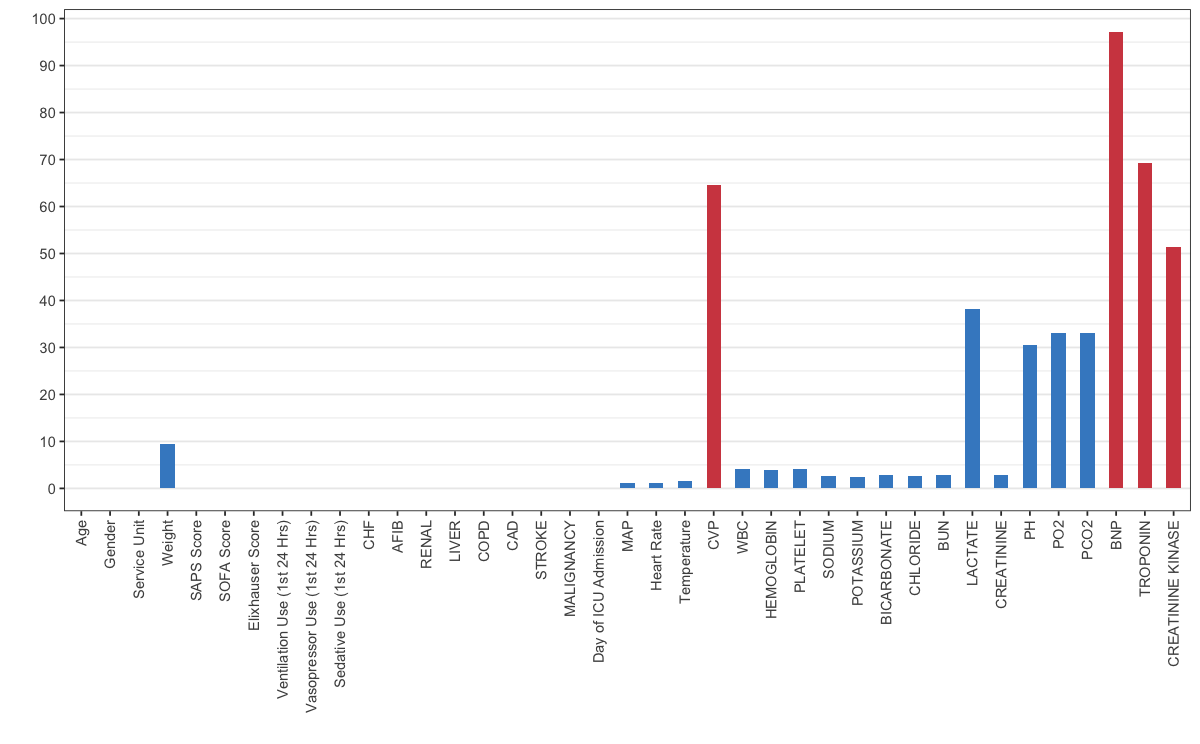

In [10]:
missing %>%
ggplot() +
geom_col(aes(x = cov, y = na, fill = as.character(flag)), width = .5) +
scale_x_discrete(limits = missing$cov) +
scale_y_continuous(breaks = seq(0, 100, 10)) +
scale_fill_manual(values = c(rgb(66, 139, 202, maxColorValue = 255),
                             rgb(210, 73, 80, maxColorValue = 255))) +
labs(x = "", y = "") +
guides(fill = FALSE) +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5),
      panel.grid.minor.x = element_blank(), panel.grid.major.x = element_blank())